# 3. 전이학습
: 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것
<h2> 1. 특성 추출 기법 </h2>
- ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막 완전연결층 부분만 새로 만듬</br>
- 즉, 학습할 때는 마지막 완전 연결층만 학습하고 나머지 계층들은 학습 X</br>
- 특성 추출은 이미지 분류를 위해 두 부분으로 구성 : 합성곱층 + 데이터분류기(완전연결층)

In [2]:
#1. 라이브러리 호출
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [8]:
data_path = '../data/catanddog/train'

In [10]:
transform = transforms.Compose(
                [
                    transforms.Resize([256,256]), 
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor()
]) #이미지 데이터를 변환하여 모델의 입력으로 사용할 수 있게 변환해줌
train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform) #transform : 이미지 데이터 전처리
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)
#데이터를 불러오는 부분으로 imageFloder을 데이터로더에 할당

In [11]:
len(train_dataset)

385

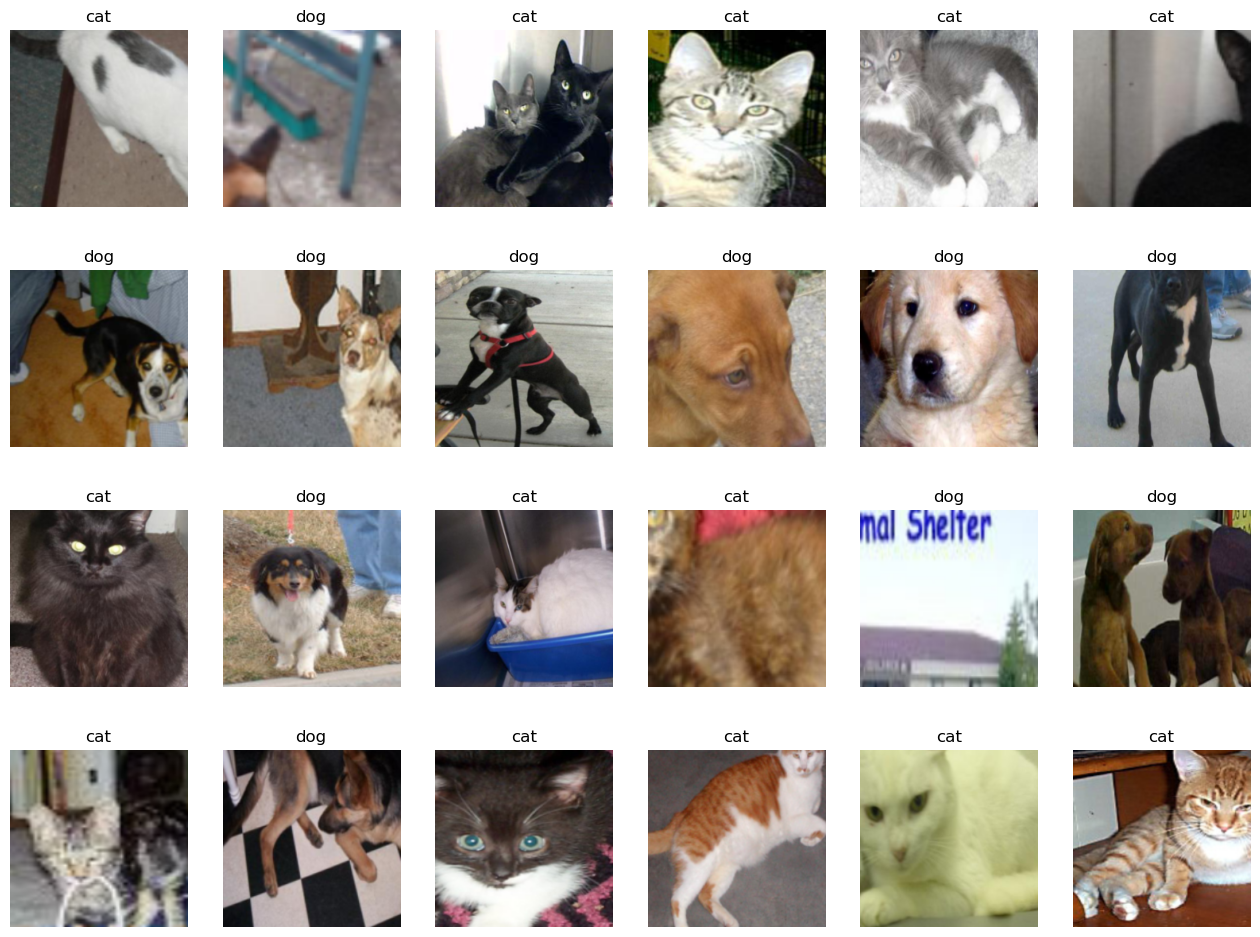

In [20]:
import numpy as np
samples, labels = next(iter(train_loader)) #train_loader에서 데이터를 하나씩 꺼내오겠다는 의미
classes = {0:'cat', 1:'dog'} #개와 고양이에 대한 클래스로 구성
fig = plt.figure(figsize=(16,24))
for i in range(24): #24개의 이미지 데이터 출력
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()]) #레이블 정보를 함께 출력
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(),(1,2,0))) #행과열을 바꾼다
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [21]:
#사전훈련된 모델 내려받기
resnet18 = models.resnet18(pretrained=True)

C:\Users\lockd\anaconda3\envs\pyTest\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\lockd\anaconda3\envs\pyTest\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting : 
        for param in model.parameters():
            param.requires_grad = False #역전파 중 파라미터들에 대한 변화를 계산할 필요가 없음

set_parameter_requires_grad(resnet18)

In [23]:
#resnet에 완전연결층 추가
resnet18.fc = nn.Linear(512,2) #2는 클래스가 두 개라는 의미
#모델의 파라미터 값 확인
for name,param in resnet18.named_parameters(): #model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
    if param.requires_grad:
        print(name,param.data)

fc.weight tensor([[-0.0440, -0.0081,  0.0155,  ...,  0.0341,  0.0096, -0.0371],
        [ 0.0316, -0.0022,  0.0375,  ..., -0.0068,  0.0138, -0.0274]])
fc.bias tensor([-0.0399,  0.0252])


In [24]:
#모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained=True) #모델의 객체 생성
for param in model.parameters(): #모델의 합성곱층 가중치 고정
    param.requires_grad = False
    
model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters(): #완전연결층은 학습
    param.requires_grad = True
    
optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss() #손실함수 정의
print(model)
    

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
#모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time() #컴퓨터의 현재 시각을 구한다
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs): #에포크 13만큼 반복
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-'*10)
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders : #데이터 로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad() #기울기를 0으로 설정
            outputs = model(inputs) #순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() # 역전파 학습
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0) #출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data) #출력결과와 레이블이 동일한지 확인한 결과를 누적하여 저장
        epoch_loss = running_loss / len(dataloaders.dataset) #평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) #평균 정확도 계산
        
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('../data/catanddog/','{0:0=2d}.pth'.format(epoch))) #모델 재사용을 위해 저장
        print()
        
    time_elapsed = time.time() - since  #실행 시간을 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history #모델의 정확도와 오차를 반환

In [38]:
#파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param) #파라미터 학습 결과를 저장
        print("\t",name)
        
optimizer = optim.Adam(params_to_update) #학습결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


In [39]:
#모델학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss() #손실함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.3566 Acc: 0.8727

Epoch 1/12
----------
Loss: 0.3533 Acc: 0.8416

Epoch 2/12
----------
Loss: 0.2815 Acc: 0.8909

Epoch 3/12
----------
Loss: 0.2626 Acc: 0.8883

Epoch 4/12
----------
Loss: 0.2395 Acc: 0.9013

Epoch 5/12
----------
Loss: 0.2689 Acc: 0.8701

Epoch 6/12
----------
Loss: 0.1929 Acc: 0.9377

Epoch 7/12
----------
Loss: 0.2186 Acc: 0.8909

Epoch 8/12
----------
Loss: 0.1691 Acc: 0.9455

Epoch 9/12
----------
Loss: 0.2114 Acc: 0.9065

Epoch 10/12
----------
Loss: 0.3048 Acc: 0.8545

Epoch 11/12
----------
Loss: 0.2262 Acc: 0.8987

Epoch 12/12
----------
Loss: 0.1838 Acc: 0.9195

Training complete in 4m 55s
Best Acc: 0.945455


In [40]:
test_path = "../data/catanddog/test"
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
test_dataset= torchvision.datasets.ImageFolder(root=test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    num_workers = 1,
    shuffle = True
)

print(len(test_dataset))

98


In [53]:
#테스트데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time() #컴퓨터의 현재 시각을 구한다
    acc_history = []
    best_acc = 0.0
    
    saved_models = glob.glob('../data/catanddog/'+'*.pth') #glob은 현재 디렉터리에서 원하는 파일들만 추출하여 가져올 때 사용. 즉 경로에서 pth 확장자를 갖는 파일을 가져오라는 의미
    #pth는 훈련 데이터로 모델을 훈련시킬 때 생성된 파일이다
    saved_models.sort() #불러온 .pth 파일들을 정렬
    print('saved_model', saved_models)
    
    for model_path in saved_models:
        print('Loading model', model_path)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0
        
        for inputs, labels in dataloaders: #테스트 반복
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad() : #autograd를 사용하지 않겠다는 의미
                outputs = model(inputs) #데이터를 모델에 적용한 결과를 outputs에 저장
            
            _, preds = torch.max(outputs.data, 1) #주어진 텐서 배열의 최댓값이 들어 있는 index를 반환하는 함수
            preds[preds >= 0.5] = 1 #torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
            preds[preds < 0.5]=0 #torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
            running_corrects += preds.eq(labels.cpu()).int().sum() #preds의 배열과 labels가 일치하는지 검사하는 용도로 사용
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
        acc_history.append(epoch_acc.item())
        print()
            
    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed //60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
        
    return acc_history #계산된 정확도 반환

In [54]:
#테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['../data/catanddog\\00.pth', '../data/catanddog\\01.pth', '../data/catanddog\\02.pth', '../data/catanddog\\03.pth', '../data/catanddog\\04.pth', '../data/catanddog\\05.pth', '../data/catanddog\\06.pth', '../data/catanddog\\07.pth', '../data/catanddog\\08.pth', '../data/catanddog\\09.pth', '../data/catanddog\\10.pth', '../data/catanddog\\11.pth', '../data/catanddog\\12.pth']
Loading model ../data/catanddog\00.pth
Acc: 0.806122

Loading model ../data/catanddog\01.pth
Acc: 0.908163

Loading model ../data/catanddog\02.pth
Acc: 0.948980

Loading model ../data/catanddog\03.pth
Acc: 0.938776

Loading model ../data/catanddog\04.pth
Acc: 0.959184

Loading model ../data/catanddog\05.pth
Acc: 0.948980

Loading model ../data/catanddog\06.pth
Acc: 0.948980

Loading model ../data/catanddog\07.pth
Acc: 0.938776

Loading model ../data/catanddog\08.pth
Acc: 0.948980

Loading model ../data/catanddog\09.pth
Acc: 0.928571

Loading model ../data/catanddog\10.pth
Acc: 0.959184

Loading model ..

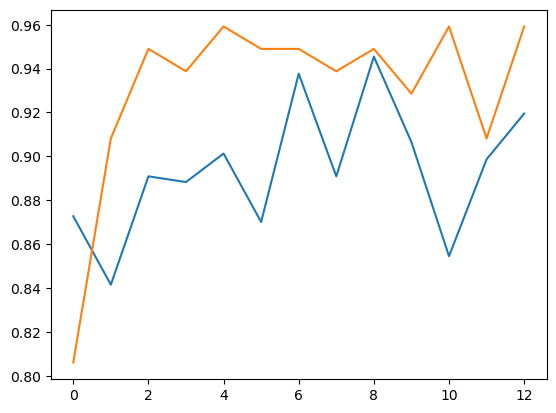

In [56]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

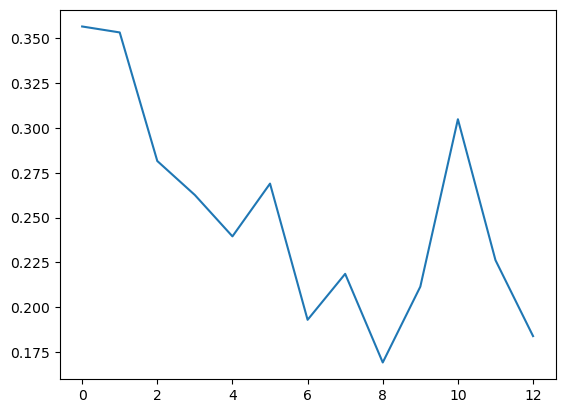

In [57]:
#훈련 데이터의 오차 그래프
plt.plot(train_loss_hist)
plt.show()

In [58]:
#예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
    image = tensor.clone().detach().numpy() #기존 텐서의 내용을 복사한 텐서를 생성한다는 의미
    #clone:새 메모리 할당. 계산그래프에 상주. detach():메모리공유. 계산그래프 상주 X, clone().detach(): 메모리 할당, 계산그래프 상주X
    image = image.transpose(1,2,0)
    image = image*(np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
    image = image.clip(0,1) #입력값이 주어진 범위를 벗어날 때 입력값을 제한
    return image

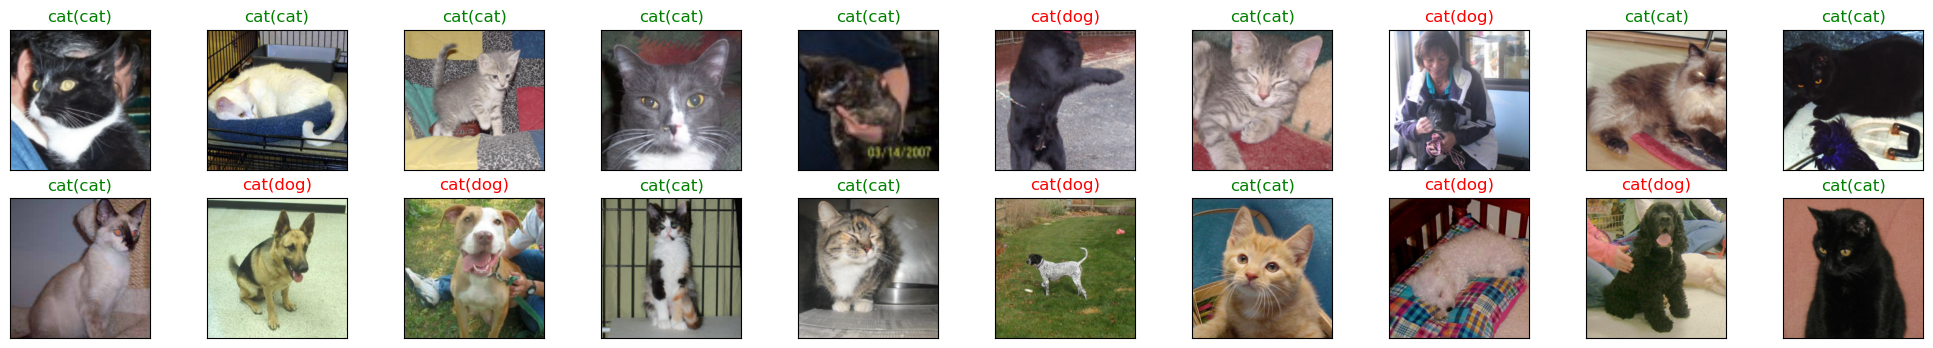

<Figure size 640x480 with 0 Axes>

In [65]:
classes = {0:'cat', 1:'dog'} #개와 고양이 두 개에 대한 레이블
dataiter = iter(test_loader) #테스트 데이터셋을 가져옴
images, labels = next(dataiter) #테스트 데이터셋에서 이미지와 레이블을 분리해서 가져옴
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) #한 화면에 여러개 이미지를 담기위해 사용
    #2행 10열, 순차적으로 출력, xy축 숫자표시X
    plt.imshow(im_convert(images[idx])) #이미지 출력을 위해 im_convert함수 적용
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
#0과 1중어떤 값을 갖는지 판별하겠다는 의미
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0) #Figure안에 서브플롯의 위치를 조정할때 사용

<h2> 2. 미세 조정 기법 </h2>
- 특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식</br>
- 데이터셋이 크고 사전 훈련된 모델과 유사성이 작을 경우 : 모델 전체 재학습</br>
- 데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우 : 합성곱층의 뒷부분과 데이터 분류기를 학습